In [1]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean as _mean, stddev as _stddev, col , collect_list
from IPython.display import display


In [2]:
import findspark
findspark.init()
findspark.find()

'C:\\Program Files\\Spark\\spark-3.5.1-bin-hadoop3'

In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("My Spark App") \
    .getOrCreate()

# load data

In [4]:
cleaned_df = spark.read.csv("cleaned_songs.csv", header=True, inferSchema=True)

print(cleaned_df.count())

32821


# prepare data for classification

In [5]:
# # remove lyrics

# cleaned_df = cleaned_df.drop("lyrics")


# normalize features (danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo) using z-scoring
features = [
    "danceability",
    "energy",
    "key",
    "loudness",
    "mode",
    "speechiness",
    "acousticness",
    "instrumentalness",
    "liveness",
    "valence",
    "tempo",
    "duration_ms",
]

for feature in features:
    stats = cleaned_df.select(
        _mean(col(feature)).alias("mean"), _stddev(col(feature)).alias("stddev")
    ).collect()
    mean = stats[0]["mean"]
    stddev = stats[0]["stddev"]

    # Normalize each feature using z-scoring
    cleaned_df = cleaned_df.withColumn(feature, (col(feature) - mean) / stddev)

    # make all values lies between -1 and 1

    min_value = cleaned_df.agg({feature: "min"}).collect()[0][0]
    max_value = cleaned_df.agg({feature: "max"}).collect()[0][0]

    value = max(abs(min_value), abs(max_value))

    cleaned_df = cleaned_df.withColumn(feature, (col(feature) / value))

# export to csv

cleaned_df.toPandas().to_csv("normalized_songs.csv", index=False)

In [18]:
from sklearn.model_selection import train_test_split

# transform the dataframe into an array of features

data = (
    cleaned_df.select(
        "genre",
        "danceability",
        "energy",
        "key",
        "loudness",
        "mode",
        "speechiness",
        "acousticness",
        "instrumentalness",
        "liveness",
        "valence",
        "tempo",
        "duration_ms",
    )
    .toPandas()
    .to_numpy()
)

# split the data into train and test sets

train_data, test_Data, train_labels, test_labels = train_test_split(
    data[:, 1:], data[:, 0], test_size=0.2, random_state=105
)

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
genres = set(train_labels)
genres = list(genres)
def get_score_confusion_matrix(model, test_Data, test_labels):
    
    score_matrix = [[0 for i in range(len(genres))] for j in range(len(genres))]
    
    for i in range(len(test_labels)):
        pred = model.predict([test_Data[i]])
        score_matrix[genres.index(test_labels[i])][genres.index(pred[0])] += 1
    #normalize the confusion matrix
    score_matrix = [[score_matrix[i][j]/sum(score_matrix[i]) for j in range(len(genres))] for i in range(len(genres))]
    return score_matrix

def draw_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(16, 5))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', xticklabels=genres, yticklabels=genres , fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
        

# SVM

### best score: 0.5236602052451539

In [8]:
from sklearn.svm import SVC
# train the model
model = SVC(kernel='rbf' )

model.fit(train_data, train_labels)


SVC()

# Random Forests

### best score: 0.5653010723123454

In [16]:
from sklearn.ensemble import RandomForestClassifier

model =RandomForestClassifier(
    n_estimators=300,
    criterion="entropy",
    max_depth=None,
    min_samples_split=2,
)

# train the model
model.fit(train_data, train_labels)

RandomForestClassifier(criterion='entropy', max_depth=20, n_estimators=300)

# decision tree

### best score: 0.47594171020071485

In [53]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(
    criterion='gini', 
    splitter='best', 
    max_depth=10, 
    min_samples_split=50, 
    min_samples_leaf=10, 
    min_weight_fraction_leaf=0.0, 
    max_features=None, 
    random_state=None, 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None, 
    ccp_alpha=0.0
)
model.fit(train_data, train_labels)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, min_samples_split=50)

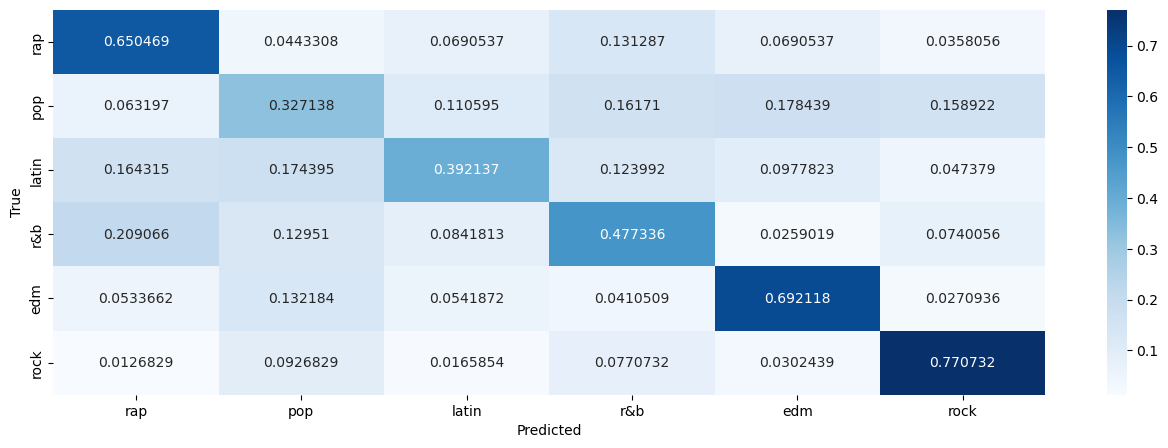

Total score: 55.64%


In [17]:
# evaluate the model
confusion_matrix = get_score_confusion_matrix(model, test_Data, test_labels)
draw_confusion_matrix(confusion_matrix)

score = model.score(test_Data, test_labels)

print (f"Total score: {score *100:.2f}%")